In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
from matplotlib import colors
import math
import os
import imageio
from collections import defaultdict

In [32]:
def initialization(L, p):
    """
    Function initializes the forest with LxL squares where the probability of a presence
    of a tree on each of the squares is equal to p, additionally the first row of trees is marked as burning
    
    Arguments:
    L -- size of the side of a forest square -- integer
    p -- probability of a presence of a tree in each of small squares - float from [0,1]
    
    Function returns:
    cmap_tree - the map with values that relate to the colors of each cell that will be used in creating images,
    list_of_trees - list of all cells that are trees in the forest,
    list_of_burning - list of all cells that are trees in the forest and are burning,
    available_squares - all squares in the forest.
    """
    squares = []
    list_of_trees = []
    list_of_empty_fields = []
    list_of_burning = []
    cmap_tree = []
    for i in range(L**2):
        rn = rnd.random()
        if rn <=p:
            list_of_trees.append(i)
            cmap_tree.append(0)
        else:
            list_of_empty_fields.append(i)
            cmap_tree.append(1)
        squares.append(i)
    available_squares = np.array(squares).reshape(L,L)
    first_row = available_squares[0:1]
    for k in first_row[0]:
        if k in list_of_trees: 
            list_of_burning.append(k)
            #list_of_trees.remove(k)
            cmap_tree[k] = 2

    cmap_tree = np.array(cmap_tree).reshape(L,L)
    return cmap_tree, list_of_trees, list_of_burning, available_squares





def neighbour(L, x, y):
    """
    Function returns the cells that are considered as a Moore's neighbourhood of a given
    tree cell (as coords of its row and column).
    
    Arguments:
    L - size of the side of a forest - integer
    x - row of a cell - integer from range [0,L]
    y - column of a cell - integer from range [0,L]
    
    Function returns the cells that are included in the Moore's neighbourhood 
    
    """
    neighbors = lambda x, y : [(x2, y2) for x2 in range(x-1, x+2)
                               for y2 in range(y-1, y+2)
                               if (-1 < x <= L and
                                   -1 < y <= L and
                                   (x != x2 or y != y2) and
                                   (0 <= x2 <= L) and
                                   (0 <= y2 <= L))]
    back = []
    for i in neighbors(x,y):
        
        back.append((L+1)*i[0]+i[1])
    return back

def vonNeumann_neighbour(L, x, y):
    """
    Function returns the cells that are considered as a von Neumann's neighbourhood of a given
    tree cell (as coords of its row and column).
    
    Arguments:
    L - size of the side of a forest - integer
    x - row of a cell - integer from range [0,L]
    y - column of a cell - integer from range [0,L]
    
    Function returns the cells that are included in von Neumann's neighbourhood 
    
    """
    neighbors = lambda x, y : [(x2, y2) for x2 in range(x-1, x+2)
                               for y2 in range(y-1, y+2)
                               if (x == x2 and y!=y2) or (y==y2 and x!=x2)
                               if (-1 < x <= L and
                                   -1 < y <= L and
                                   (x != x2 or y != y2) and
                                   (0 <= x2 <= L) and
                                   (0 <= y2 <= L))]
    back = []
    for i in neighbors(x,y):
        
        back.append((L+1)*i[0]+i[1])
    return back

def image(data, cmap, no, p):
    """
    Function creates an image of an actual state of a burning forest and saves it in the folder.
    It represents the burning forest with colors as follows:
    green - living tree
    white - an empty square
    red - a burning tree
    black - a burned tree
    
    Aguments:
    data -- actual state of the forest - numpy array
    cmap -- color map of the state of the forest - numpy array
    no - number of the step of the simulation - integer
    p - initial probability (described in initialization) - float from range [0,1]
    
    Function doesn't return anything, just saves images
    """
    cmap = colors.ListedColormap(['green', 'white', 'red', 'black'])
    bounds=[-0.5,0.5,1.5,2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots()
    img = plt.imshow(data, interpolation='nearest', origin='lower',
                        cmap=cmap, norm=norm)
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.title("Forest fire, p = "+str (p))

    fig = plt.gcf()
    fig.savefig("Figure" + str(no) + ".png",dpi = 200)
    plt.close()

def read_row_col(tree, L):
    """
    Helper function converting the number of a given tree number into its coordinates.
    
    Arguments:
    tree - number of a tree in the forest - integer from range[0,LxL-1]
    L - size of the side of a forest square - integer
    
    Function returns the tuple of the coordinates of a given tree
    """
    col = tree%L
    row = math.floor(tree/L)
    return (row,col)


def forest_fire(L, cmap_tree, list_of_trees, list_of_burning, available_squares, p, images = False):
    """
    Function simulating the next steps of a forest fire algorithm. It works until at least one tree is burning.
    
    Arguments:
    L - size of the side of a forest square - integer
    cmap_tree - the map with values that relate to the colors of each cell that will be used in creating images - numpy array
    list_of_trees - list of all cells that are trees in the forest - list
    list_of_burning - list of all cells that are trees in the forest and are burning - list
    available_squares - all squares in the forest - numpy array
    p - probability described before
    optional argument: images - True if images are to be created, False if otherwise
    
    Function returns the final state of the simulation with the same objects that were provided as arguments 
    as well as a list of the trees that were burned and survived throughout the simulation.
    """
    cmap = cmap_tree
    ct = 0
    list_of_burned = []
    list_of_unburned =  list(set(list(set(list_of_trees) - set(list_of_burning))) - set(list_of_burned))
    while len(list_of_burning) !=0:
        if images == True:
            image(cmap_tree,cmap,ct, p)
        list_of_unburned =  list(set(list(set(list_of_trees) - set(list_of_burning))) - set(list_of_burned))
        newly_burned = []
        for tree in list_of_unburned:
            row, col = read_row_col(tree, L)
            neighbor_list = neighbour(L-1,row,col)
            burning_as_set = set(list_of_burning)
            intersection = burning_as_set.intersection(neighbor_list)
            if len(intersection)!=0:
                newly_burned.append(tree)
        list_of_burned.extend(list_of_burning)
        list_of_burning = newly_burned
        if images == True:
            for i in list_of_burned:
                r,c = read_row_col(i, L)
                cmap[r,c] = 3

            for i in newly_burned:
                r,c = read_row_col(i, L)
                cmap[r,c] = 2
            ct+=1
    if images == True:
            image(cmap_tree,cmap,ct, p)
    return list_of_trees, list_of_burning, available_squares, list_of_burned, list_of_unburned

def forest_fire_stats(L, available_squares, list_of_burned):
    """
    Helper function that determines whether the fire reached the other and of the forest during one simulation
    
    Arguments: 
    L - size of the side of a forest square - integer
    available_squares - all squares in the forest - numpy array
    list_of_burned - list of all trees that were burned in one simualtion - list
    
    Function returns 1 if the simulation reached the other end and 0 otherwise.
    """
    last_row = available_squares[L-1:L]
    count = 0
    for j in last_row[0]:
        if j in list_of_burned:
            count = 1
            return count
    if count == 0:
        return count
    
def merge_common(lists):
    """
    Helper function that merges nested lists in a list if they have a common part.
    
    Arguments:
    lists - a list of nested lists
    
    Function returns the list with merged nested lists
    """
    neigh = defaultdict(set)
    visited = set()
    for each in lists:
        for item in each:
            neigh[item].update(each)
    def comp(node, neigh = neigh, visited = visited, vis = visited.add):
        nodes = set([node])
        next_node = nodes.pop
        while nodes:
            node = next_node()
            vis(node)
            nodes |= neigh[node] - visited
            yield node
    for node in neigh:
        if node not in visited:
            yield sorted(comp(node))

def forest_fire_clusters(L,available_squares, list_of_burned):
    """
    Function that calculates the biggest cluster of a burned trees using the von Neumann's neighborhood.
    
    Arguments: 
    L - size of the side of a forest square - integer
    available_squares - all squares in the forest - numpy array
    list_of_burned - list of all trees that were burned in one simualtion - list
    
    Function returns the size of a biggest cluster.
    """
    checked = []
    clusters = []
    for tree in range(len(list_of_burned)):
        row, col = read_row_col(list_of_burned[tree], L)
        nei_list = vonNeumann_neighbour(L-1, row, col)
        burned_as_set = set(list_of_burned)
        intersection = list(burned_as_set.intersection(nei_list))
        clusters.append(intersection)
        clusters[tree].append(list_of_burned[tree])      
    connected = list(merge_common(clusters))
    max_len = 0
    for i in connected:
        if len(i)>max_len:
            max_len = len(i)
    return max_len
    
    
def create_gif(path, duration):
    """
    Function creates gif from the images that are already in the given directory
    
    Arguments: 
    path - path where the images are being stored - string
    duration - duration in seconds of a each step of the simulation in the gif
    
    Function only creates gif and doesn't return anything.
    """
    images = []
    dirs = os.listdir(path)
    new_images = sorted(dirs, key = len)
    for file in new_images:
        if file.endswith(".png"):
                images.append(imageio.imread(file))
    kargs = { 'duration': duration }
    imageio.mimsave(path+"\\Forest_fire.gif", images,**kargs)    
            
def MC_reaching_other_end(list_of_p, L, loops = 50):
    """
    Function that conducts Monte Carlo simulations checking whether the fire reached the other end of the forest
    in a forest fire algorithm instance.
    
    Arguments:
    list_of_p - list of the probability values - list of floats
    L - size of the side of the forest square - integer
    optional argument: loops - number of the Monte Carlo simulations
    
    Function returns the list of values in which each of the numbers corresponds to the value of probability.
    """
    count_list = []
    for p_ast in p_list:
        helper = []
        for l in range(loops):
            init = initialization(L, p_ast)
            forest = forest_fire(L,init[0],init[1],init[2],init[3], False)
            helper.append(forest_fire_stats(L, forest[2], forest[3]))
        count_list.append(np.sum(helper)/loops)
    return count_list

def calc_p_star(values, list_of_p):
    """
    Function that calculates the p^asterix which serves the purpose of a point on x axis where the growth of the fraction
    of simulations that reached the other end of the forest is the biggest.
    
    Arguments:
    values - list of values that is returned by MC_reaching_other_end function
    list_of_p - list of the probability values - list of floats
    """
    diffs = 0
    p_star = list_of_p[0]
    for i in range(len(list_of_p)-1):
        difference = values[i+1]-values[i]
        if difference > diffs:
            diffs = difference
            p_star = (list_of_p[i+1]+list_of_p[i])/2
    return p_star


In [33]:
L = 20
p = 0.44
b = initialization(L, p)
forest = forest_fire(L,b[0],b[1],b[2],b[3], p, True)



In [34]:
create_gif("C:\\Users\\user\\Desktop\\Applied mathematics\\Semestr 2\\Agent based modelling\\List 1", 0.3)

In [6]:
p_list = [y/100 for y in range(2, 101, 2)]
L=100
loops = 50
MC_cluster=[]
for p_p in p_list:
    helper = []
    for i in range(loops):
        init = initialization(L, p_p)
        forest = forest_fire(L,init[0],init[1],init[2],init[3], p_p, False)
        clust = forest_fire_clusters(L,forest[2], forest[3])
        helper.append(clust)
    MC_cluster.append(np.sum(helper)/loops)

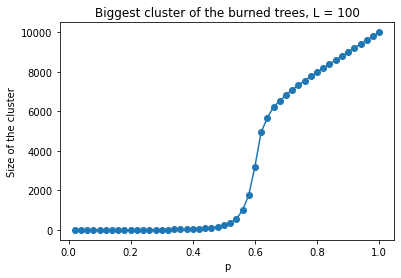

In [31]:
plt.figure()
plt.plot(p_list,MC_cluster,'-o')
plt.ylabel("Size of the cluster")
plt.xlabel("p")
plt.title("Biggest cluster of the burned trees, L = 100")
fig = plt.gcf()
fig.savefig("Biggest cluster L100.png",dpi = 200)
plt.show()

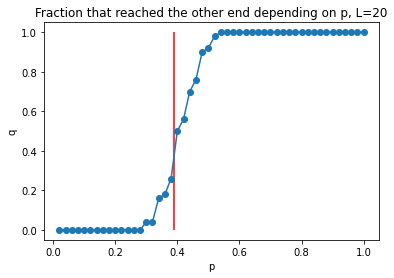

In [16]:
list_20 = MC_reaching_other_end(p_list, 20)
p_20 = calc_p_star(list_20, p_list)
plt.figure()
plt.plot(p_list,list_20,'-o')
plt.vlines(p_20, 0, 1, color = "red")
plt.xlabel("p")
plt.ylabel("q")
plt.title("Fraction that reached the other end depending on p, L=20")
fig = plt.gcf()
fig.savefig("Monte Carlo, reaching other end, L20.png",dpi = 200)
plt.show()

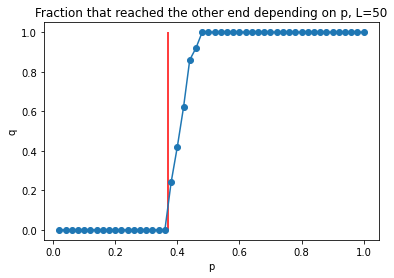

In [17]:
#list_50 = MC_reaching_other_end(p_list, 50)
p_50 = calc_p_star(list_50, p_list)
plt.figure()
plt.plot(p_list,list_50,'-o')
plt.vlines(p_50, 0, 1, color = "red")
plt.xlabel("p")
plt.ylabel("q")
plt.title("Fraction that reached the other end depending on p, L=50")
fig = plt.gcf()
fig.savefig("Monte Carlo, reaching other end, L50.png",dpi = 200)
plt.show()

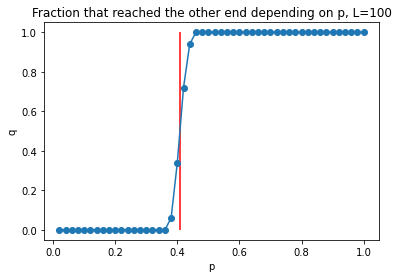

In [18]:
#list_100 = MC_reaching_other_end(p_list, 100)
p_100 = calc_p_star(list_100, p_list)
plt.figure()
plt.plot(p_list,list_100,'-o')
plt.vlines(p_100, 0, 1, color = "red")
plt.xlabel("p")
plt.ylabel("q")
plt.title("Fraction that reached the other end depending on p, L=100")
fig = plt.gcf()
fig.savefig("Monte Carlo, reaching other end, L100.png",dpi = 200)
plt.show()